## M4M SQA -- Project Outline 

### 1. Data Preparation and Feature Engineering
- **Acquire training features (`train_feature`).**
- **Obtain heart rate data for training (`train_hr`) and testing (`test_hr`).**

### 2. Feature Selection and Model Training
- **Import the feature map.**
- **Select features for the model.**
- **Train the model using the selected features.**
- **Save the trained (`ML model`) and compare (`different ML model`).**

### 3. Experiment I: Quality Estimation Test
- **Acquire the test feature (`test_feature`) using selected features and save it as a CSV file.**
- **Import test data and the model, then perform the testing.**

### 4. Experiment II: Heart Rate Estimation
- **Add prediction labels to test data and merge with PPG heart rate data.**
- **Prepare the ECG heart rate as ground truth.**
- **Merge PPG and ECG heart rate data.**
- **Generate plots and metrics from the PPG and ECG heart rate data.**


In [ ]:
# Firstly, select 'each_slice_length' in Data_loading.py file.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from Data_loading import fs, dt, each_slice_length, save_model_and_scalers, load_model_and_scalers, load_and_filter_data 
from Train_models import molti_ROC1, model_compare1,select_features 
from Test_models import evaluate_model, evaluate_and_compare_models, train_and_select_features  
from Feature_extraction import analyse  
from HR_processing import prepare_predict_label, prepare_final_df, create_final_ecg_hr_data,create_final_ecg_MIMIC_hr_data, plot_ecg_ppg_mae_combined  

import warnings
seed = 42
np.random.seed(seed)
warnings.filterwarnings('ignore')

# 1, Get train_feature, train_hr and test_hr

####  Logic: 1, get train feature   2,train_hr   3,test_hr

In [5]:
# Check experimental parameters
each_slice_length

60

In [ ]:
# 1.1 Get train dataset features

csv_file1 = analyse('train_SR', 'SR', map_type="feature",selected_features=None)
csv_file2 = analyse('train_AF', 'AF', map_type="feature",selected_features=None)

train_feature = pd.concat([csv_file1, csv_file2], ignore_index=True)

dir_path = f'Model_feature_hr_save1/data_{each_slice_length}s/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/train_{each_slice_length}s_feature.csv'
train_feature.to_csv(file_path, index=False)

In [21]:
# 1.2 Get train_hr

csv_file1 = analyse('train_SR', 'SR', map_type="hr",selected_features=None)
csv_file2 = analyse('train_AF', 'AF', map_type="hr",selected_features=None)

train_hr = pd.concat([csv_file1, csv_file2], ignore_index=True)

file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/train_{each_slice_length}s_hr.csv'
train_hr.to_csv(file_path, index=False)

In [22]:
# 1.3 Get test_hr

csv_file1 = analyse('test_SR', 'SR', map_type="hr",selected_features=None)
csv_file2 = analyse('test_AF', 'AF', map_type="hr",selected_features=None)

test_hr = pd.concat([csv_file1, csv_file2], ignore_index=True)
    
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/test_{each_slice_length}s_hr.csv'
test_hr.to_csv(file_path, index=False)

# 2, Feature selection then train ML model then save model

#### the method for feature selection is RLScore. 
Logic: 1, import feature map. 
2,feature selection. 
3,train model with selected features. 
4,save this model
5,compare different models
6,also save these model

In [6]:
# 2.1, import feature map. 
# 
model_type='SR_AF' # SR_AF  or SR or AF  pick data to train
# model_type='SR'
# model_type='AF'

train_data = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='train', map_type='feature',is_mimic=False)
train_data


,c1_Waveform_Correlation_Index,c2_Euclidean_Distance,c5_Dynamic_Correlation_Index,A6_Signal_Consistency_Range,B1_Std_of_PSD,A7_Cardiac_Pulse_Power,C3_Linear_Resampling,C4_Clipping_Quality_Index,A1_SQI2_skewness,A2_Kurtosis_Index,A3_Shannon_Entropy,A4_Zero_Cross_Rate,A5_Absolute_Signal_to_noise_Ratio,B2_Relative_Power_SQI,A8_Lempel_Ziv_Complexity,label_list,dataset_label,label
0,0.183535,12.398490,0.989036,0.830558,2.329484,45066.562172,0.183535,0.898163,2.095899,19.829856,12.813203,0.054167,1.118074,0.424240,0.053125,dropna_1075PPG.csv,SR,1
1,0.020137,3.767490,0.993938,0.352890,0.402348,8593.082976,0.020137,0.975000,0.754072,61.247576,7.016977,0.068490,1.068654,0.478277,0.067969,dropna_1075PPG.csv,SR,1
2,0.235856,5.315609,0.994834,0.470162,0.455937,6673.585790,0.235856,0.958933,3.448773,34.861257,13.240187,0.057552,1.107530,0.438597,0.058073,dropna_1075PPG.csv,SR,1
3,0.316194,1.032939,0.875434,0.088129,0.021002,363.567132,0.316194,0.999117,1.808850,35.861261,-31.344482,0.070573,1.081648,0.460655,0.070312,dropna_1075PPG.csv,SR,1
4,0.377516,0.771514,0.826560,0.098439,0.023709,384.047316,0.377516,0.998068,1.879306,60.135808,-29.321748,0.066146,1.090419,0.282244,0.065625,dropna_1075PPG.csv,SR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14275,0.189018,0.355334,0.993770,0.067665,0.001767,20.464793,0.189018,1.000000,1.093455,8.575654,-383.756702,0.070833,1.289625,0.387052,0.067969,dropna_1090PPG.csv,AF,0
14276,0.111694,0.325790,0.981566,0.047099,0.008364,85.122084,0.111694,0.999320,0.404024,34.601352,-162.299498,0.070573,1.073749,0.143711,0.070833,dropna_1090PPG.csv,AF,0
14277,0.222837,0.178018,0.985179,0.039948,0.000791,7.778133,0.222837,1.000000,3.514055,61.643523,-580.307317,0.074740,1.182270,0.383276,0.073958,dropna_1090PPG.csv,AF,0
14278,0.218980,0.184951,0.982291,0.042942,0.000607,9.066596,0.218980,1.000000,1.396989,24.956662,-701.264245,0.079687,1.254160,0.330997,0.078906,dropna_1090PPG.csv,AF,0


In [8]:
# 2.2 feature selection.
top_features = train_and_select_features(train_data, max_features=5)

Features selected 1, test error 0.130828, accuracy 0.843978
Features selected 2, test error 0.120682, accuracy 0.856022
Features selected 3, test error 0.114034, accuracy 0.869468
Features selected 4, test error 0.110141, accuracy 0.873950
Features selected 5, test error 0.108180, accuracy 0.875630
test error 0.108180
Selected feature names:
Index(['A5_Absolute_Signal_to_noise_Ratio', 'c2_Euclidean_Distance',
       'c1_Waveform_Correlation_Index', 'A8_Lempel_Ziv_Complexity',
       'A7_Cardiac_Pulse_Power'],
      dtype='object')
Selected features [12, 1, 0, 14, 5]


In [10]:
#  Parameter setting
random_state = 42
clf = LogisticRegression(random_state=random_state, max_iter=1000)

# Shuffle
data = train_data.sample(frac=1, random_state=42)

features = [
      'A6_Signal_Consistency_Range', 'B1_Std_of_PSD',
    'A7_Cardiac_Pulse_Power', 'C3_Linear_Resampling', 'C4_Clipping_Quality_Index',
    'A1_SQI2_skewness', 'A2_Kurtosis_Index', 'A3_Shannon_Entropy', 'A4_Zero_Cross_Rate',
    'A5_Absolute_Signal_to_noise_Ratio', 'B2_Relative_Power_SQI', 'A8_Lempel_Ziv_Complexity'
]

datasets = {feature: data[[feature, 'label_list', 'dataset_label', 'label']] for feature in features}

datasets['All'] = data[features + ['label_list', 'dataset_label', 'label']]

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=random_state),
    'GBDT': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state),
    'SVC': SVC(kernel='linear', gamma='auto', degree=1, cache_size=5000, probability=True, random_state=random_state),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_state),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=random_state)
}

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
    '#98df8a', '#ff9896', '#c5b0d5',  'red','#c49c94'
]
lines = ['solid'] * len(features) + ['solid']

Model and scalers have been saved to Model_feature_hr_save1/Model_SR_AF_120s/models_and_scalers_lg_120s.pkl


,ROC AUC,Accuracy,Sensitivity,Precision,F1-Score
A5_Absolute_Signal_to_noise_Ratio,0.879155,0.837395,0.899750,0.801660,0.847877
c2_Euclidean_Distance,0.833745,0.749720,0.677697,0.795106,0.731722
A7_Cardiac_Pulse_Power,0.823507,0.723039,0.552558,0.843558,0.667731
C3_Linear_Resampling,0.877857,0.807003,0.848443,0.785530,0.815775
A8_Lempel_Ziv_Complexity,0.652219,0.627871,0.660317,0.623228,0.641237
All,0.940114,0.874230,0.903504,0.855000,0.878583


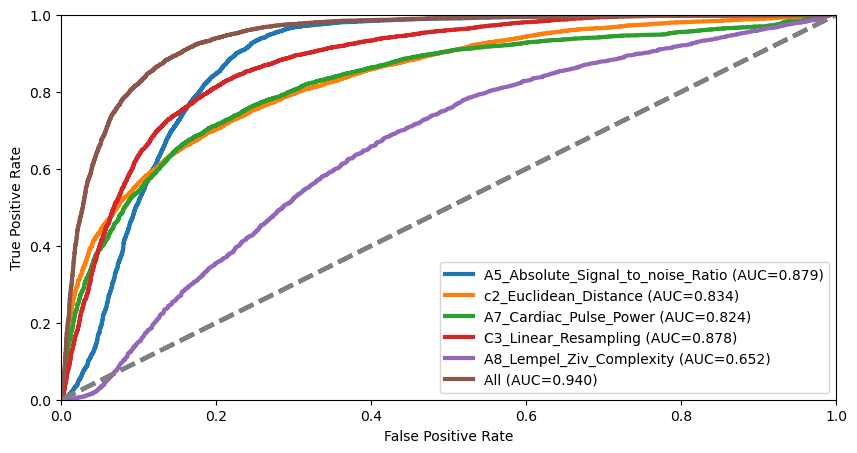

In [12]:
# 2.3 train one model with selected features and save one(lg) model. 

selected_features = ['A5_Absolute_Signal_to_noise_Ratio', 'c2_Euclidean_Distance',
       'A7_Cardiac_Pulse_Power', 'C3_Linear_Resampling',
       'A8_Lempel_Ziv_Complexity','All']

selected_datasets = select_features(selected_features, data)
plt, results_df,trained_models,trained_scalers = molti_ROC1(selected_features, selected_datasets, colors, lines)

save_model_and_scalers(trained_models['All'], trained_scalers['All'], model_type, each_slice_length, "one")

results_df

### 2.4. train multi models with selected features and save All model. 

Model and scalers have been saved to Model_feature_hr_save1/Model_SR_AF_120s/models_and_scalers_120s.pkl


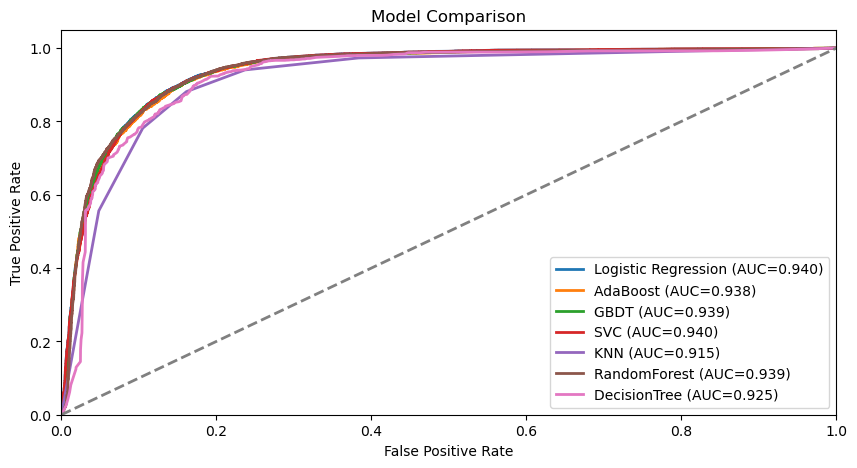

In [14]:
# 2.4. train multi models with selected features and save All model.
plt, results_df_concat2, trained_diff_models,trained_diff_scalers = model_compare1(list(classifiers.keys()), list(classifiers.values()), selected_datasets[-1], colors, lines)
results_df_concat2

# save multi model
save_model_and_scalers(trained_diff_models, trained_diff_scalers, model_type, each_slice_length, "All")

# 3, Experiment I: Quality estimation

#### Test with selected feature
logic: 1, get test feature map (selected feature) and save into csv. 2,import test data, model, and then test it.

In [20]:
# 3.1.1 Get test feature map

selected_features = ['A5_Absolute_Signal_to_noise_Ratio', 'c2_Euclidean_Distance',
       'A7_Cardiac_Pulse_Power', 'C3_Linear_Resampling',
       'A8_Lempel_Ziv_Complexity','All']

csv_file1= analyse('test_SR','SR', map_type="feature", selected_features=selected_features)
csv_file2 = analyse('test_AF','AF',map_type="feature", selected_features=selected_features)

test_feature = pd.concat([csv_file1, csv_file2], ignore_index=True)
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/test_{each_slice_length}s_feature.csv'
test_feature.to_csv(file_path, index=False)


In [21]:
# 3.1.2 Get test_mimic hr map

csv_file1= analyse('test_mimiciv','SR', map_type="hr",selected_features=None)
csv_file2 = pd.DataFrame(columns=csv_file1.columns)

test_mimic = pd.concat([csv_file1, csv_file2], ignore_index=True)
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/test_mimic_{each_slice_length}s_hr.csv'
test_mimic.to_csv(file_path, index=False)


In [22]:
# 3.1.3 Get test_mimic feature all map
csv_file1= analyse('test_mimiciv','SR', map_type="feature",selected_features=None)
csv_file2 = pd.DataFrame(columns=csv_file1.columns)

test_mimic = pd.concat([csv_file1, csv_file2], ignore_index=True)
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/train_mimic_{each_slice_length}s_feature.csv'
test_mimic.to_csv(file_path, index=False)

In [23]:
# 3.1.4 Get test_mimic selected features map
csv_file1= analyse('test_mimiciv','SR', map_type="feature",selected_features=selected_features)
csv_file2 = pd.DataFrame(columns=csv_file1.columns)

test_mimic = pd.concat([csv_file1, csv_file2], ignore_index=True)
file_path = f'Model_feature_hr_save1/data_{each_slice_length}s/test_mimic_{each_slice_length}s_feature.csv'
test_mimic.to_csv(file_path, index=False)

## Start now

In [8]:
# 3.2 Load test data

model_type='SR_AF'
# model_type='SR'
# model_type='AF'

test_data = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='feature',is_mimic=False)
test_data

,A5_SQI6_signal_to_noise_ratio,c2_euclidean,A7extract_heart_cycle_energy,C3linear_resampling_sqi,A8_lempel_ziv_complexity,label_list,dataset_label,label
0,0.965561,0.800287,197.839161,0.111777,0.072917,dropna_1101PPG.csv,SR,1
1,0.695000,0.186978,2.631689,0.294597,0.075521,dropna_1101PPG.csv,SR,1
2,0.675325,0.171907,2.321713,0.398978,0.063542,dropna_1101PPG.csv,SR,1
3,0.973306,0.686337,237.486428,0.063072,0.064062,dropna_1101PPG.csv,SR,1
4,0.925790,0.264134,18.959484,0.084788,0.066667,dropna_1101PPG.csv,SR,1
...,...,...,...,...,...,...,...,...
31945,0.761343,4.733241,1701.624291,0.111134,0.062500,dropna_1518PPG.csv,AF,1
31946,0.955061,0.389429,102.773303,-0.165195,0.076563,dropna_1518PPG.csv,AF,1
31947,0.539939,0.140712,1.183928,0.340742,0.084896,dropna_1518PPG.csv,AF,0
31948,0.704552,0.147293,1.880305,0.305948,0.083854,dropna_1518PPG.csv,AF,0


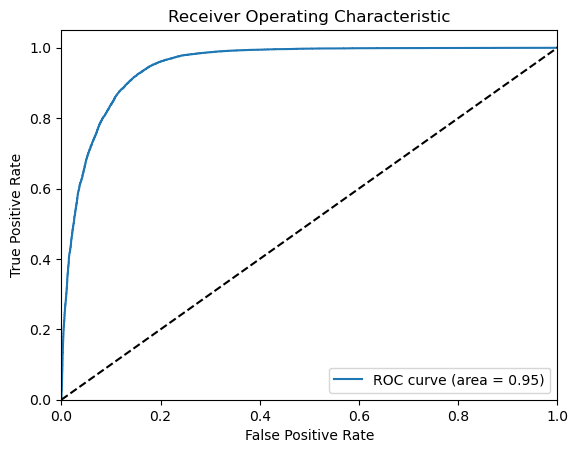

Accuracy: 0.8779655712050078
Recall: 0.8672964169381108
Precision: 0.8772981878088962
F1 Score: 0.8722686322686324
ROC AUC: 0.9490992739688393


In [10]:
# Load one lg model

model_type='SR_AF'
# model_type='SR'
# model_type='AF'

final_trained_model, final_trained_scalers = load_model_and_scalers(model_type, each_slice_length, model_number = 'one')

# test one lg model
evaluate_model(test_data, final_trained_model, final_trained_scalers)

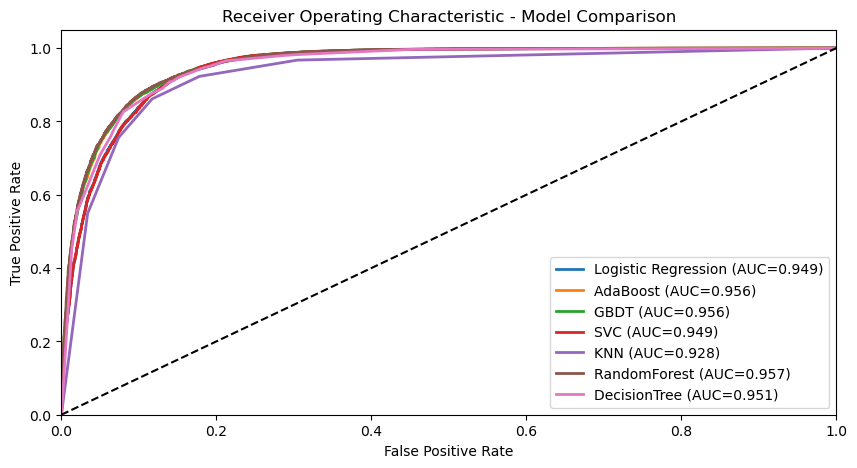

,ROC AUC,Accuracy,Sensitivity,Precision,F1-Score
Logistic Regression,0.949099,0.877966,0.867296,0.877298,0.872269
AdaBoost,0.955502,0.886260,0.888274,0.876623,0.882410
GBDT,0.955661,0.885352,0.887818,0.875329,0.881529
SVC,0.948903,0.879437,0.880000,0.870473,0.875211
KNN,0.928322,0.872551,0.861433,0.871770,0.866571
RandomForest,0.956545,0.887981,0.887883,0.880028,0.883938
DecisionTree,0.950690,0.879280,0.890814,0.862441,0.876398


In [12]:
# Load multi models
trained_diff_models, trained_diff_scalers = load_model_and_scalers(model_type, each_slice_length, model_number = 'All')

# test multi model
metrics_df = evaluate_and_compare_models(test_data, trained_diff_models, trained_diff_scalers)
metrics_df

In [13]:
# 3.2 Load test data for mimic

model_type='SR_AF'
# model_type='SR'
# model_type='AF'

test_data = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='feature',is_mimic=True)
test_data

,A5_SQI6_signal_to_noise_ratio,c2_euclidean,A7extract_heart_cycle_energy,C3linear_resampling_sqi,A8_lempel_ziv_complexity,label_list,dataset_label,label
0,0.743793,3.038490,944.414487,0.711980,0.108333,80713046_Pleth_processed_resampled_modified.csv,SR,1
1,0.628336,3.309429,1402.454458,0.807555,0.146875,80713046_Pleth_processed_resampled_modified.csv,SR,0
2,0.640744,3.573721,1234.768225,0.681736,0.122396,80713046_Pleth_processed_resampled_modified.csv,SR,0
3,0.720133,3.441873,927.702513,0.585556,0.090104,80713046_Pleth_processed_resampled_modified.csv,SR,0
4,0.609595,3.748848,1566.440527,0.743288,0.110417,80713046_Pleth_processed_resampled_modified.csv,SR,0
...,...,...,...,...,...,...,...,...
4983,0.516626,4.257067,1587.056441,0.574445,0.066667,89821554_Pleth_processed_resampled_modified.csv,SR,0
4984,0.542131,4.352636,1384.017335,0.519188,0.060417,89821554_Pleth_processed_resampled_modified.csv,SR,1
4985,0.556084,4.803054,1473.452669,0.412677,0.068229,89821554_Pleth_processed_resampled_modified.csv,SR,1
4986,0.512064,4.324139,1523.376577,0.542301,0.067708,89821554_Pleth_processed_resampled_modified.csv,SR,0


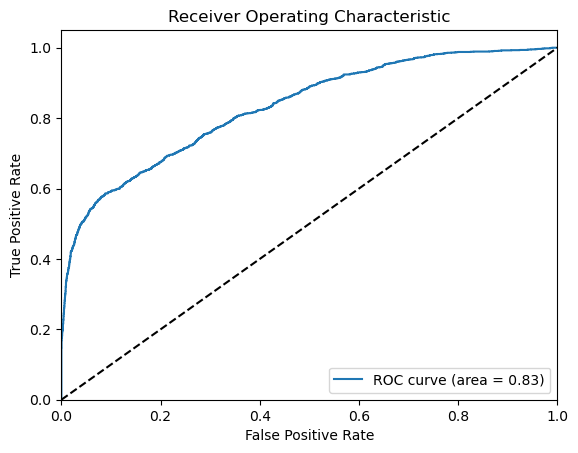

Accuracy: 0.7786688051323175
Recall: 0.3960852043753598
Precision: 0.9259757738896366
F1 Score: 0.5548387096774194
ROC AUC: 0.8312953438709881


In [14]:
# Load one lg model
model_type='SR_AF'
# model_type='SR'
# model_type='AF'

final_trained_model, final_trained_scalers = load_model_and_scalers(model_type, each_slice_length, model_number = 'one')

# test one lg model
evaluate_model(test_data, final_trained_model, final_trained_scalers)


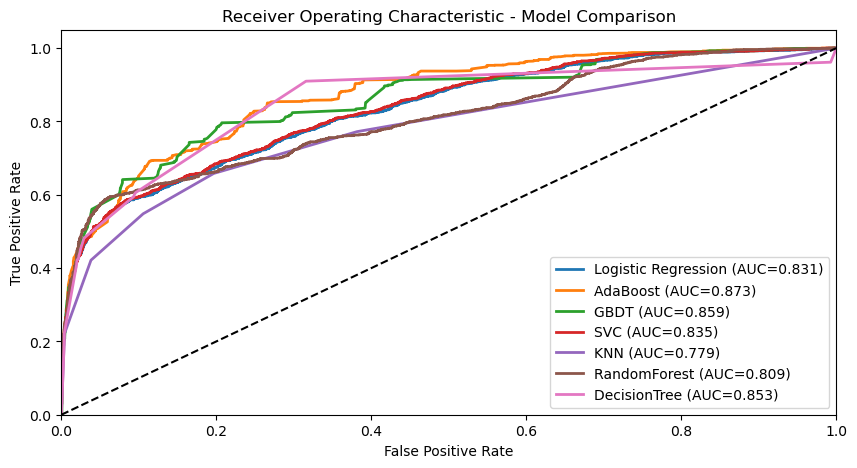

,ROC AUC,Accuracy,Sensitivity,Precision,F1-Score
Logistic Regression,0.831295,0.778669,0.396085,0.925976,0.554839
AdaBoost,0.872653,0.795710,0.454231,0.917442,0.607624
GBDT,0.858568,0.786087,0.424295,0.916667,0.580087
SVC,0.834904,0.787891,0.435233,0.907563,0.588327
KNN,0.779223,0.773857,0.548071,0.735135,0.627968
RandomForest,0.809122,0.808941,0.502015,0.908333,0.646644
DecisionTree,0.852862,0.786287,0.428325,0.910649,0.582616


In [15]:
# Load multi models
trained_diff_models, trained_diff_scalers = load_model_and_scalers(model_type, each_slice_length, model_number = 'All')

# test multi model
metrics_df = evaluate_and_compare_models(test_data, trained_diff_models, trained_diff_scalers)
metrics_df

# 4, Experiment II: HR estimation

#### This part comtain predict label/PPG_hr/final PPG_HR/ECG_HR/Plot & metrics
Logic: 1, Add predict label to test data and merge hr_ppg and predict label. 2, Prepare test ECG_HR as ground true. 3. merge PPG_HR and ECG_HR. 4, Get Plot and metrics from PPG_HR & ECG_HR 

In [20]:
# 4.1, Add predict label to test data (quality label)  and merge predict quality label with PPG HR. 

model_type='SR_AF'
test_feature = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='feature',is_mimic=True)

predict_label = prepare_predict_label(test_feature, final_trained_model, final_trained_scalers)

test_ppg_hr = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='hr',is_mimic=True)

ppg_hr = prepare_final_df(test_ppg_hr, predict_label)

ppg_hr.to_csv('ppg_hr_data.csv', index=False)
ppg_hr

,PPG_HR_withoutfilter,PPG_HR_SDSD,PPG_HR_auto60s,label,Subject_Number,Count,Pred_label
0,82.515723,NaN,85.333333,1,80713046,0,0
1,89.538951,89.934641,90.995261,0,80713046,1,0
2,89.633952,90.150922,82.500000,0,80713046,2,0
3,88.137715,88.867235,78.513011,0,80713046,3,0
4,88.460733,89.040512,90.887574,0,80713046,4,0
...,...,...,...,...,...,...,...
4921,64.673684,63.376623,63.529412,1,89821554,392,0
4922,60.448239,59.181980,59.534884,0,89821554,393,0
4923,65.961945,NaN,63.734440,0,89821554,394,0
4924,63.420352,63.420352,61.538462,1,89821554,395,0


In [22]:
ecg_hr=create_final_ecg_MIMIC_hr_data(mimic_directory='New_M4M/test_mimiciv/MIMIC_ECG/')

In [23]:
ecg_hr.to_csv('ecg_hr_data.csv', index=False)
ecg_hr

,ECG_HR,Subject_Number,Health_label,Count
0,50.526316,80713046,MIMIC,0
1,87.272727,80713046,MIMIC,1
2,64.340426,80713046,MIMIC,2
3,88.739496,80713046,MIMIC,3
4,89.559748,80713046,MIMIC,4
...,...,...,...,...
4921,74.348509,89821554,MIMIC,392
4922,87.685039,89821554,MIMIC,393
4923,75.432163,89821554,MIMIC,394
4924,81.055409,89821554,MIMIC,395


In [26]:
# 4.3 merge PPG_HR and ECG_HR. 

ecg_hr['Subject_Number'] = ecg_hr['Subject_Number'].astype(str)
ppg_hr['Subject_Number'] = ppg_hr['Subject_Number'].astype(str)

merged_data_mimic = pd.merge(ecg_hr, ppg_hr, on=['Count', 'Subject_Number'], suffixes=('_ecg', '_ppg'))
merged_data_mimic.to_csv('merged_data_mimic.csv', index=False)
merged_data_mimic

,ECG_HR,Subject_Number,Health_label,Count,PPG_HR_withoutfilter,PPG_HR_SDSD,PPG_HR_auto60s,label,Pred_label
0,50.526316,80713046,MIMIC,0,82.515723,NaN,85.333333,1,0
1,87.272727,80713046,MIMIC,1,89.538951,89.934641,90.995261,0,0
2,64.340426,80713046,MIMIC,2,89.633952,90.150922,82.500000,0,0
3,88.739496,80713046,MIMIC,3,88.137715,88.867235,78.513011,0,0
4,89.559748,80713046,MIMIC,4,88.460733,89.040512,90.887574,0,0
...,...,...,...,...,...,...,...,...,...
4921,74.348509,89821554,MIMIC,392,64.673684,63.376623,63.529412,1,0
4922,87.685039,89821554,MIMIC,393,60.448239,59.181980,59.534884,0,0
4923,75.432163,89821554,MIMIC,394,65.961945,NaN,63.734440,0,0
4924,81.055409,89821554,MIMIC,395,63.420352,63.420352,61.538462,1,0


In [28]:
# 4.1, Add predict label to test data (quality label)  and merge predict quality label with PPG HR. 
# FOR PHILIPS data
model_type='SR_AF'
test_feature = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='feature',is_mimic=False)

predict_label = prepare_predict_label(test_feature, final_trained_model, final_trained_scalers)

test_ppg_hr = load_and_filter_data(each_slice_length=each_slice_length, model_type=model_type, data_type='test', map_type='hr',is_mimic=False)

ppg_hr = prepare_final_df(test_ppg_hr, predict_label)
ppg_hr

# 4.2, Prepare test ECG_HR as ground true.
ecg_hr = create_final_ecg_hr_data(SR_directory = 'New_M4M/test_SR/ann_add/', AF_directory = 'New_M4M/test_AF/ann_add/')
ecg_hr

merged_data = pd.merge(ecg_hr, ppg_hr, on=['Count', 'Subject_Number'], suffixes=('_ecg', '_ppg'))
merged_data

,ECG_HR,Adjusted_Time_seconds,Subject_Number,Health_label,Count,PPG_HR_withoutfilter,PPG_HR_SDSD,PPG_HR_auto60s,label,Pred_label
0,103.173028,0.0,1099,AF,0,54.827586,NaN,60.000000,1,1
1,58.645878,60.0,1099,AF,1,51.557465,NaN,49.230769,1,1
2,62.314242,120.0,1099,AF,2,52.202284,NaN,51.891892,1,1
3,56.719418,180.0,1099,AF,3,51.779935,NaN,59.076923,1,1
4,56.032761,780.0,1099,AF,4,50.635091,NaN,60.000000,1,1
...,...,...,...,...,...,...,...,...,...,...
28489,1.668706,68880.0,4103,SR,1127,59.124797,59.124797,62.950820,0,0
28490,78.284344,69540.0,4103,SR,1128,60.423223,60.397351,62.836364,0,0
28491,94.672872,69600.0,4103,SR,1129,59.413681,59.207048,64.719101,1,1
28492,105.356155,69660.0,4103,SR,1130,51.309460,NaN,NaN,1,1


In [29]:
combined_data = pd.concat([merged_data_mimic, merged_data], ignore_index=True, join='inner')
combined_data

,ECG_HR,Subject_Number,Health_label,Count,PPG_HR_withoutfilter,PPG_HR_SDSD,PPG_HR_auto60s,label,Pred_label
0,50.526316,80713046,MIMIC,0,82.515723,NaN,85.333333,1,0
1,87.272727,80713046,MIMIC,1,89.538951,89.934641,90.995261,0,0
2,64.340426,80713046,MIMIC,2,89.633952,90.150922,82.500000,0,0
3,88.739496,80713046,MIMIC,3,88.137715,88.867235,78.513011,0,0
4,89.559748,80713046,MIMIC,4,88.460733,89.040512,90.887574,0,0
...,...,...,...,...,...,...,...,...,...
33415,1.668706,4103,SR,1127,59.124797,59.124797,62.950820,0,0
33416,78.284344,4103,SR,1128,60.423223,60.397351,62.836364,0,0
33417,94.672872,4103,SR,1129,59.413681,59.207048,64.719101,1,1
33418,105.356155,4103,SR,1130,51.309460,NaN,NaN,1,1


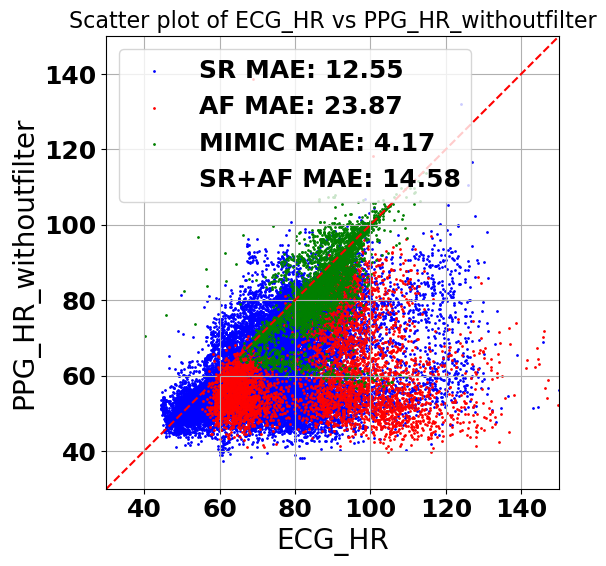

In [95]:
# plt.style.use('article.mplstyle')
# 4.4 Get Plot and metrics from PPG_HR & ECG_HR 
# 'SR' means on SR data | 'PPG_HR_SDSD' means HR with SDSD filter | filter_label='label' means use Manual Labeling |'Pred_label' means model Labeling
# consider_label = True  means use data with good quality (from predict or manullly)

health_labels_and_colors = [('SR', 'blue'), ('AF', 'red'),('MIMIC','green')]

config = {
    'ppg_hr_column': 'PPG_HR_withoutfilter',  # or 'PPG_HR_auto60s' or 'PPG_HR_withoutfilter'
    'consider_label': False,  # or False
    'filter_label': 'Pred_label'  # or 'label'Pred_label
}

plot_ecg_ppg_mae_combined(combined_data, health_labels_and_colors, 
                          ppg_hr_column=config['ppg_hr_column'], 
                          consider_label=config['consider_label'], 
                          filter_label=config['filter_label'])

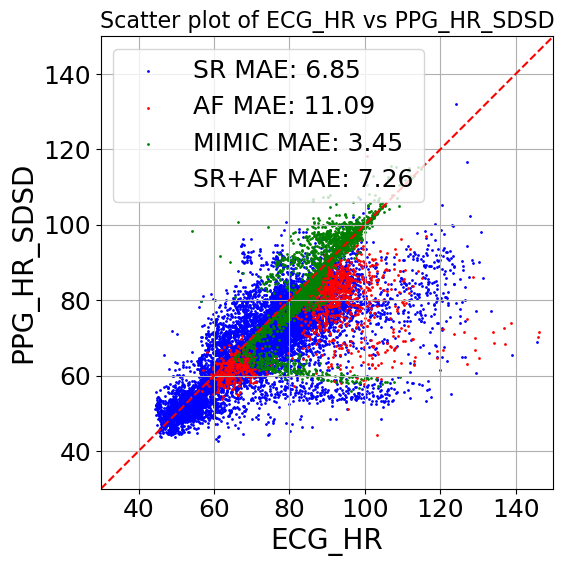

In [72]:
health_labels_and_colors = [('SR', 'blue'), ('AF', 'red'),('MIMIC','Green')]

config = {
    'ppg_hr_column': 'PPG_HR_SDSD',  # or 'PPG_HR_auto60s' or 'PPG_HR_withoutfilter'
    'consider_label': True,  # or False
    'filter_label': 'Pred_label'  # or 'label'
}


plot_ecg_ppg_mae_combined(combined_data, health_labels_and_colors, 
                          ppg_hr_column=config['ppg_hr_column'], 
                          consider_label=config['consider_label'], 
                          filter_label=config['filter_label'])

#### 